The spatial Correlation between sea surface temperature anomaly and sea surface height anomaly in the Indian Ocean -- A demo using ECCO
===========================
### Author: Edward Armstrong and Jinbo Wang
### Date: 2022-02-15

### Objective

This tutorial will use data from the Estimating the Climate and Circulation of the Ocean (ECCO) model to derive spatial correlations through time for two regions of the Indian Ocean.
The goal is to investigate the correlative characteristics of the Indian Ocean Dipole and how the east and west regions behave differently.  This investigation was motivated by Fig 2 a,b in the paper by Wang et al. (2016). 

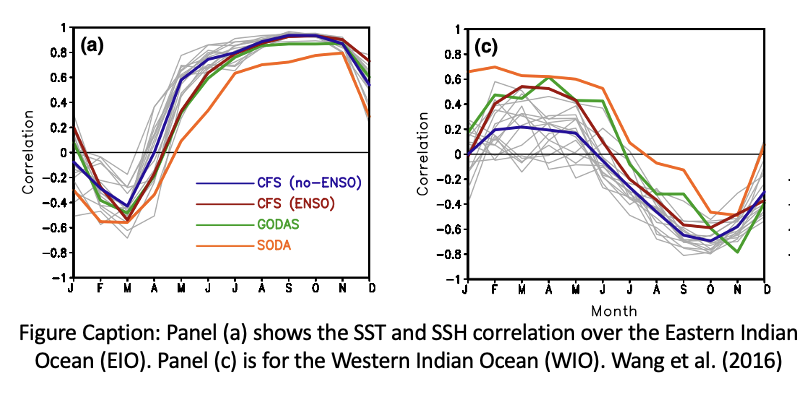

* Wang, H., Murtugudde, R. & Kumar, A. Evolution of Indian Ocean dipole and its forcing mechanisms in the absence of ENSO. Clim Dyn 47, 2481–2500 (2016). https://doi.org/10.1007/s00382-016-2977-y

### Input datasets

1. ECCO Ocean Temperature and Salinity - Monthly Mean 0.5 Degree (Version 4 Release 4).  DOI: 10.5067/ECG5M-OTS44
1. ECCO Sea Surface Height - Daily Mean 0.5 Degree (Version 4 Release 4b).  DOI: 10.5067/ECG5D-SSH4B

### Services and software used

1. NASA Harmony netcdf-to-Zarr
1. xarray, requests, json, pandas, numpy, matplotlib, **s3fs**
1. Various python utlities

# Import various libraries

In [1]:
from matplotlib import pylab as plt
import xarray as xr
import numpy as np
import pandas as pd
import requests
import json
import time
import s3fs
import re

# Identify the ShortName of the dataset of interest.

The shortname is an unique pointer for each NASA dataset. 

In [2]:
ShortName = "ECCO_L4_SSH_05DEG_MONTHLY_V4R4B"

## Set start and end dates


In [3]:
start_date = "2016-01-02"
#start_date = "2017-01-02"
#end_date   = "2017-12-31"
end_date   = "2017-12-31"

## Spatial bounds (Region of Interest) -- Not used

In [4]:
westernmost_longitude = 100.
easternmost_longitude = 150.
northermost_latitude  = 30.
southernmost_latitude = 0.

# Find the concept_id

In [5]:
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]

ccid = ummc['meta']['concept-id']

ccid

'C2129189405-POCLOUD'

# NetCDF to Zarr transformation
## Setup the Harmony service call

In [6]:
base = f"https://harmony.earthdata.nasa.gov/{ccid}"
hreq = f"{base}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset"
rurl = f"{hreq}?format=application/x-zarr"

#print(rurl)

subs = '&'.join([f'subset=time("{start_date}T00:00:00.000Z":"{end_date}T23:59:59.999Z")']) 
#subs = subs + '&' + '&'.join([f'subset=lat({southernmost_latitude}:{northermost_latitude})'])
#subs = subs + '&' + '&'.join([f'subset=lon({westernmost_longitude}:{easternmost_longitude})'])

rurl = f"{rurl}&{subs}"

print('harmony URL: \n',rurl)

harmony URL: 
 https://harmony.earthdata.nasa.gov/C2129189405-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=time("2016-01-02T00:00:00.000Z":"2017-12-31T23:59:59.999Z")


You can also wrapper these code into one function:

In [7]:
def get_harmony_url(ccid,start_date,end_date):
    """
    Parameters:
    ===========
    ccid: string
        concept_id of the datset
    date_range: list
        [start_data, end_date] 
        
    Return:
    =======
    url: the harmony URL used to perform the netcdf to zarr transformation
    """
    
    base = f"https://harmony.earthdata.nasa.gov/{ccid}"
    hreq = f"{base}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset"
    rurl = f"{hreq}?format=application/x-zarr"

    #print(rurl)

    subs = '&'.join([f'subset=time("{start_date}T00:00:00.000Z":"{end_date}T23:59:59.999Z")']) 
    #subs = subs + '&' + '&'.join([f'subset=lat({southernmost_latitude}:{northermost_latitude})'])
    #subs = subs + '&' + '&'.join([f'subset=lon({westernmost_longitude}:{easternmost_longitude})'])

    rurl = f"{rurl}&{subs}"
    return rurl

ccid='C2129189405-POCLOUD'
print(get_harmony_url(ccid,start_date,end_date))

https://harmony.earthdata.nasa.gov/C2129189405-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=time("2016-01-02T00:00:00.000Z":"2017-12-31T23:59:59.999Z")


# Submit the request and monitor the progress

This submission will trigger a backend program that does the conversation. The output will be saved and linked. 

In [12]:
response = requests.get(url=rurl).json()

print(response)
print

# Monitor status in a while loop. Wait 10 seconds for each check.
wait = 10
while True:
    #response = requests.get(url=response['links'][0]['href']).json()
    response = requests.get(url=response['links'][-1]['href']).json()
    #print(response)
    if response['status']!='running':
        break
    print(f"Job in progress ({response['progress']}%)")
    time.sleep(wait)

print("DONE!")


{'username': 'edward.m.armstrong', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2022-02-24T18:01:39.353Z', 'updatedAt': '2022-02-24T18:01:39.353Z', 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/0d53c2a5-6335-4ad5-b97c-aac6658b341e?page=1&limit=2000', 'title': 'The current page', 'type': 'application/json', 'rel': 'self'}], 'request': 'https://harmony.earthdata.nasa.gov/C2129189405-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application%2Fx-zarr&subset=time(%222016-01-02T00%3A00%3A00.000Z%22%3A%222017-12-31T23%3A59%3A59.999Z%22)', 'numInputGranules': 24, 'jobID': '0d53c2a5-6335-4ad5-b97c-aac6658b341e'}
Job in progress (0%)
Job in progress (8%)
Job in progress (29%)
Job in progress (37%)
Job in progress (62%)
Job in progress (79%)
DONE!


#  Access the staged cloud datasets over native AWS interfaces

In [13]:
print(response['message'])
with requests.get(response['links'][2]['href']) as r:
    creds = r.json()

print( creds.keys() )

creds['Expiration']

The job has completed successfully. Contains results in AWS S3. Access from AWS us-west-2 with keys from https://harmony.earthdata.nasa.gov/cloud-access.sh
dict_keys(['AccessKeyId', 'SecretAccessKey', 'SessionToken', 'Expiration'])


'2022-02-25T02:09:30.000Z'

# List zarr datasets with s3fs 

In [14]:
s3_dir = response['links'][3]['href']

print("root directory:", s3_dir)

s3_urls = [u['href'] for u in response['links'][4:-1]]

# sort the URLs in time order
s3_urls.sort()

print(s3_urls[0])
#print(s3_urls)

s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

len(s3.ls(s3_dir))

root directory: s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/70ed154d-c876-47ca-9628-6d594823a241/
s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/70ed154d-c876-47ca-9628-6d594823a241/SEA_SURFACE_HEIGHT_mon_mean_2016-01_ECCO_V4r4b_latlon_0p50deg.zarr


24

# Open datasets with xarray()

In [15]:
ds0 = xr.open_zarr(s3.get_mapper(s3_urls[0]), decode_cf=True, mask_and_scale=True)
ds0
#s3_urls[0]
#s3_urls

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 2016-01-16T12:00:00
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2016-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2016-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         d643d67a-d083-4df5-b8d5-a8a07bf35553

# Concatenate all granules (datasets) via  a loop

In [28]:
ssh_ds = xr.concat([xr.open_zarr(s3.get_mapper(u)) for u in s3_urls], dim="time", coords='minimal')
ssh_ds
#ssh_ds_group = xr.concat([xr.open_zarr(s3.get_mapper(u)) for u in s3_urls], dim="time", coords='minimal').groupby('time.month')

<xarray.Dataset>
Dimensions:         (longitude: 720, time: 24, latitude: 360, nv: 2)
Coordinates:
  * longitude       (longitude) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
    longitude_bnds  (longitude, nv) float32 -180.0 -179.5 -179.5 ... 179.5 180.0
  * time            (time) datetime64[ns] 2016-01-16T12:00:00 ... 2017-12-16T...
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2016-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2016-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         d643d67a-d083-4df5-b8d5-a8a07bf35553

# Rinse and Repeat all steps  for the second (ocean/salinity temperature) dataset
## Run 2nd Harmony netCDF-to-Zarr call

In [22]:
ShortName = "ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4"

# 1) Find new concept_id for this dataset
response = requests.get(
        url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
        params={'provider': "POCLOUD",
                'ShortName': ShortName,
                'page_size': 1}
)

ummc = response.json()['items'][0]
ccid = ummc['meta']['concept-id']

# 2) Insert new concept_id in existing harmony URL 
rurl = re.sub('C.*-POCLOUD', ccid, rurl )

# 3) Execute harmony netCDF to Zarr request
response = requests.get(url=rurl).json()
print(response)

# Monitor status in a while loop. Wait 10 seconds for each check.
wait = 10
while True:
        response = requests.get(url=response['links'][-1]['href']).json()
        if response['status']!='running':
            break
        print(f"Job in progress ({response['progress']}%)")
        time.sleep(wait)

print("DONE!")

{'username': 'edward.m.armstrong', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2022-02-24T18:16:57.492Z', 'updatedAt': '2022-02-24T18:16:57.492Z', 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/d17e197a-1d32-4530-b4b4-9c786ccbde93?page=1&limit=2000', 'title': 'The current page', 'type': 'application/json', 'rel': 'self'}], 'request': 'https://harmony.earthdata.nasa.gov/C1990404795-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application%2Fx-zarr&subset=time(%222016-01-02T00%3A00%3A00.000Z%22%3A%222017-12-31T23%3A59%3A59.999Z%22)', 'numInputGranules': 24, 'jobID': 'd17e197a-1d32-4530-b4b4-9c786ccbde93'}
Job in progress (0%)
Job in progress (12%)
Job in progress (25%)
Job in progress (41%)
Job in progress (62%)
Job in progress (75%)
Job in progress (91%)
DONE!


## Read the S3 Zarr endpoints and aggregate to single Zarr

In [25]:
print(response['message'])
#len(response['links'])

#print(len(response['links']))

# 1) read the AWS credentials
with requests.get(response['links'][2]['href']) as r:
    creds = r.json()
print( creds.keys() )
print( creds['Expiration'] )

# 2) print root directory and read the s3 URLs into a list
s3_dir2 = response['links'][3]['href']
print("root directory:", s3_dir2)
s3_urls2 = [u['href'] for u in response['links'][4:-1]]

# sort the URLs in time order
s3_urls2.sort()

# 3) Autenticate AWS S3 credentials
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)
# print( len(s3.ls(s3_dir2)) )

# 4) Read and concatenate into a single Zarr dataset
temp_ds = xr.concat([xr.open_zarr(s3.get_mapper(u)) for u in s3_urls2], dim="time", coords='minimal')
#temp_ds_group = xr.concat([xr.open_zarr(s3.get_mapper(u)) for u in s3_urls2], dim="time", coords='minimal').groupby('time.month')

temp_ds


The job has completed successfully. Contains results in AWS S3. Access from AWS us-west-2 with keys from https://harmony.earthdata.nasa.gov/cloud-access.sh
dict_keys(['AccessKeyId', 'SecretAccessKey', 'SessionToken', 'Expiration'])
2022-02-25T02:21:48.000Z
root directory: s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/c2dd0756-80c8-474d-9a20-58fa0038ee52/


<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, time: 24, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float64 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float64 -89.75 -89.25 -88.75 ... 89.25 89.75
    Z_bnds          (Z, nv) float32 nan -10.0 -10.0 ... -5.678e+03 -6.134e+03
    latitude_bnds   (latitude, nv) float32 -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 -180.0 -179.5 -179.5 ... 179.5 180.0
  * time            (time) datetime64[ns] 2016-01-16T12:00:00 ... 2017-12-16T...
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 dask.array<chunksize=(1, 50, 280, 280), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 dask.array<chunksize=(1, 50, 280, 280), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2016-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2016-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            8599f964-4159-11eb-9ba9-0cc47a3f7e53

## Do data masking, calculate a SST anomaly, and plot some figures 

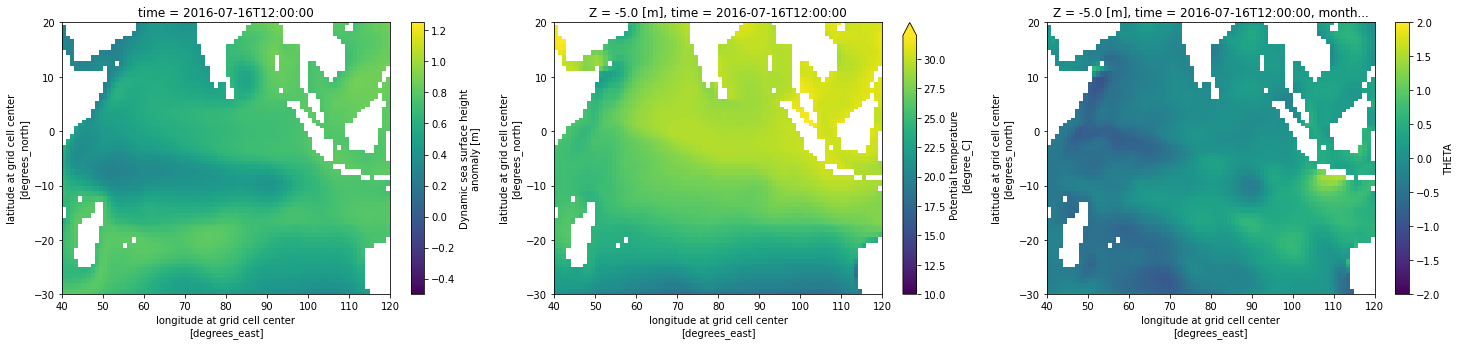

In [26]:
# Mask for the good data. Everything else defaults to NaN
# SST missing value 9.9692100e+36  
# SSH missing value 9.9692100e+36
cond = (ssh_ds < 1000)
ssh_ds_masked = ssh_ds['SSH'].where(cond)

cond = (temp_ds < 1000)
temp_ds_masked = temp_ds['THETA'].where(cond)

# Derive a SST climatology and subtract it from the SST to create SST anomaly and remove trends
climatology_mean = temp_ds_masked.groupby('time.month').mean('time',keep_attrs=True,skipna=False)
temp_ds_masked_anomaly = temp_ds_masked.groupby('time.month') - climatology_mean  # subtract out longterm monthly mean

fig,ax=plt.subplots(1,3,figsize=(25,5))

# take a slice of the Indian Ocean and plot SSH, SST, SST anomaly
ssh_ds_masked['SSH'][6].sel(longitude=slice(40,120),latitude=slice(-30,20)).plot(ax=ax[0], vmin=-0.5,vmax=1.25)
temp_ds_masked['THETA'][6].sel(longitude=slice(40,120),latitude=slice(-30,20), Z=slice(0,-5)).plot(ax=ax[1], vmin=10,vmax=32)
temp_ds_masked_anomaly['THETA'][6].sel(longitude=slice(40,120),latitude=slice(-30,20), Z=slice(0,-5)).plot(ax=ax[2], vmin=-2,vmax=2)


## Perform the correlations in the east and west Indian Ocean

 Running correlations in eastern Indian Ocean . . .

 Running correlations in western Indian Ocean . . .



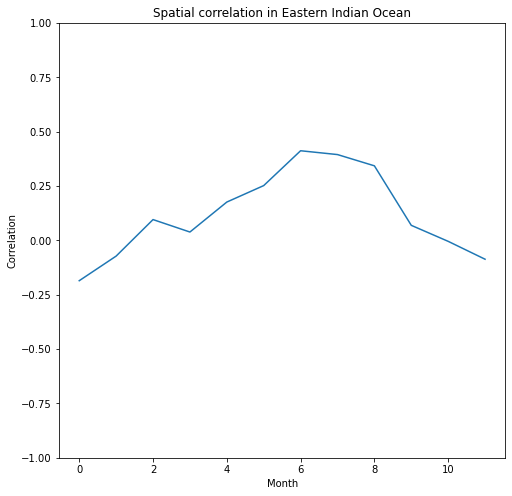

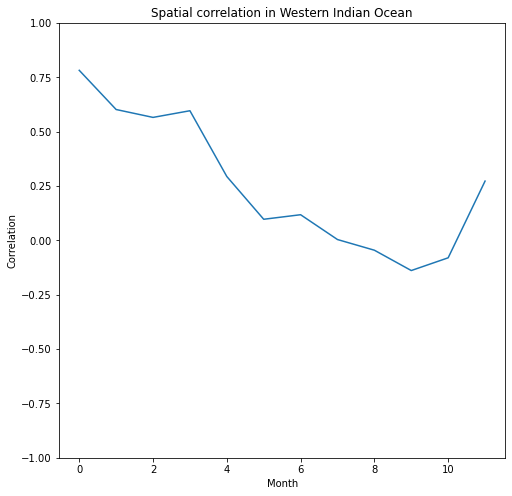

In [27]:
# Western and Eastern Indian Ocean regions (WIO and EIO respectively)
# EIO; 90 –110 E, 10 S–0N
# WIO; 50 –70 E, 10 S–10 N

# Group Eastern Indian Ocean  data by month. This will make the correlation of all monthly values straightforwrd.
ssh_group = ssh_ds_masked['SSH'].sel(longitude=slice(90,110),latitude=slice(-10,0)).groupby('time.month')
#temp_group = temp_ds_masked['THETA'].sel(longitude=slice(90,110),latitude=slice(-10,0), Z=-5.0).drop('Z').groupby('time.month')
temp_group = temp_ds_masked_anomaly['THETA'].sel(longitude=slice(90,110),latitude=slice(-10,0), Z=-5.0).drop('Z').groupby('time.month')

print(" Running correlations in eastern Indian Ocean . . .\n")  
corr = []
for month in range(1,13):
    corr.append(xr.corr(ssh_group[month], temp_group[month]))
    #print("\nthe correlation in the east is: " , xr.corr(ssh_group[month], temp_group[month]).values)
    
# Do some plotting
fig,ax=plt.subplots(1,2,figsize=(14,8))

ax[0].set_title("Spatial correlation in Eastern Indian Ocean",fontsize=16)
ax[0].set_ylabel("Correlation",fontsize=16)
ax[0].set_xlabel("Month",fontsize=16)
ax[0].set_ylim([-1, 1])
ax[0].plot(corr)

# Repeat for Western Indian Ocean
# Group the data by month. This will make the correlation of all monthly values straightforwrd.
ssh_group = ssh_ds_masked['SSH'].sel(longitude=slice(50,70),latitude=slice(-10,10)).groupby('time.month')
#temp_group = temp_ds_masked['THETA'].sel(longitude=slice(50,70),latitude=slice(-10,10), Z=-5.0).drop('Z').groupby('time.month')
temp_group = temp_ds_masked_anomaly['THETA'].sel(longitude=slice(50,70),latitude=slice(-10,10), Z=-5.0).drop('Z').groupby('time.month')


print(" Running correlations in western Indian Ocean . . .\n") 
corr2 =[]
for month in range(1,13):
    corr2.append(xr.corr(ssh_group[month], temp_group[month]))
    #print("\nthe correlation in the west is: " , xr.corr(ssh_group[month], temp_group[month]).values)
    
ax[1].set_title("Spatial correlation in Western Indian Ocean",fontsize=16)
ax[1].set_ylabel("Correlation",fontsize=16)
ax[1].set_xlabel("Month",fontsize=16)
ax[1].set_ylim([-1, 1])
ax[1].plot(corr2)

# End